In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from config import get_from_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_FLAT = pd.read_csv('meas_FLAT.csv', index_col=0)
theor_FLAT = pd.read_csv('theor_df_FLAT.csv', index_col=0)

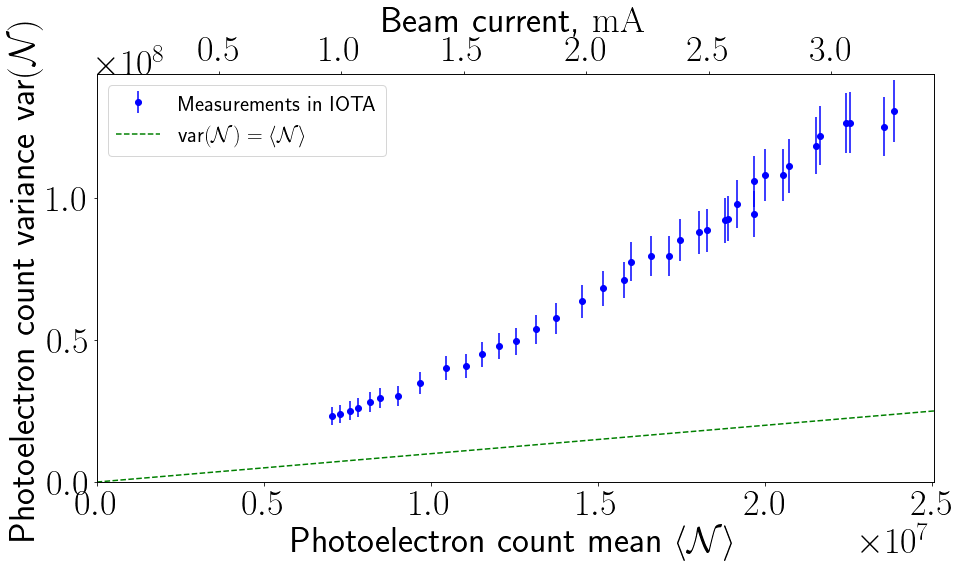

In [80]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_FLAT['N'],meas_FLAT['varN'],marker='o',linestyle='None',yerr=meas_FLAT['errorbar'],color='b',
            label = r'Measurements in IOTA')
ax.plot(theor_FLAT['N'], theor_FLAT['N'],color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")

ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_FLAT['N'].max())
ax.set_ylim(0, 1.1*meas_FLAT['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [69]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [70]:
import scipy.optimize as optimize
def reconstruct_sy(avN, varN, sx, sz):
    Mexp = avN**2/(varN-avN)
    def f(syv):
        return Mfunc(sx,syv,sz)-Mexp
    return optimize.bisect(f,1,1500)

In [71]:
reconstruct_sy(1e7, 0.3e8, 1000, 25)

199.6368559820508

In [72]:
meas_FLAT['Sigma_um_Y_Meas'] = meas_FLAT.apply(
    lambda row: reconstruct_sy(*row[['N', 'varN', 'Sigma_um_X', 'N:IWCMBE']]), axis=1)
meas_FLAT['varNtop'] = meas_FLAT['varN']+meas_FLAT['errorbar']
meas_FLAT['varNbottom'] = meas_FLAT['varN']-meas_FLAT['errorbar']
meas_FLAT['Sigma_um_Y_Meas_Top'] = meas_FLAT.apply(
    lambda row: reconstruct_sy(*row[['N', 'varNbottom', 'Sigma_um_X', 'N:IWCMBE']]), axis=1)-meas_FLAT['Sigma_um_Y_Meas']
meas_FLAT['Sigma_um_Y_Meas_Bottom'] = -meas_FLAT.apply(
    lambda row: reconstruct_sy(*row[['N', 'varNtop', 'Sigma_um_X', 'N:IWCMBE']]), axis=1)+meas_FLAT['Sigma_um_Y_Meas']

In [73]:
meas_FLAT['I_mA'] = meas_FLAT['N']*N_to_I

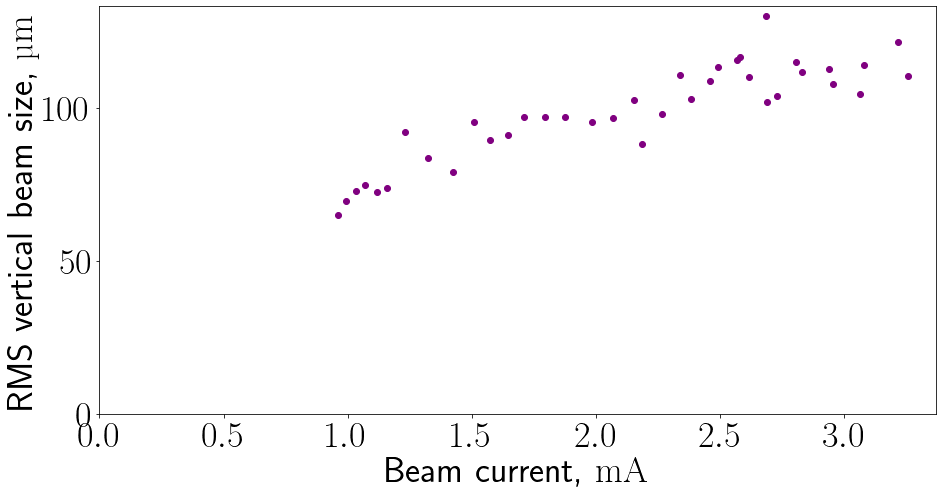

In [79]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
fig, ax = plt.subplots(figsize=(15, 7.5))
yerr = 0#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
ax.errorbar(meas_FLAT['I_mA'], meas_FLAT['Sigma_um_Y_Meas'], marker='o', linestyle='None',
            color='purple', yerr=yerr)
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Beam current, \SI{}{mA}')
ax.set_ylabel('RMS vertical beam size, \SI{}{\micro m}')
plt.show()